# Вторичная задача

## Импорт необходимых библиотек

In [1]:
!pip install -U kaleido
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import sklearn
import io

from PIL import Image
from geopy.distance import geodesic
from sklearn.neighbors import KDTree
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

LARGE, MEDIUM, SMALL = 22, 16, 12

PARAMS = {'axes.titlesize': LARGE,
          'legend.fontsize': MEDIUM,
          'figure.figsize': (16, 10),
          'axes.labelsize': MEDIUM,
          'axes.titlesize': MEDIUM,
          'xtick.labelsize': MEDIUM,
          'ytick.labelsize': MEDIUM,
          'figure.titlesize': LARGE}

plt.rcParams.update(PARAMS)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_style("white")

## Сбор данных

In [4]:
merchants_train = pd.read_csv("merchants_train.csv", sep=';')
merchants_test = pd.read_csv("merchants_test.csv", sep=';')

transactions_full = pd.read_csv("transactions.csv")

## Анализ данных

Создадим копии данных, которые будем анализировать для того, чтобы изменения не касались исходных данных:

In [5]:
merchants = merchants_train.copy()
transactions = transactions_full.copy()

Теперь рассмотрим данные чуть подробнее. Начнем с `merchants` - датасет, содержащий истинные расположения мерчантов.

In [6]:
merchants

,merchant_id,latitude,longitude
0,178,55.055553,82.911833
1,267,55.726877,37.579645
2,357,54.706402,20.471420
3,505,64.553811,40.551964
4,532,55.768355,49.217176
...,...,...,...
6477,1786127,55.713755,37.889762
6478,1827295,55.656707,37.855770
6479,1834870,55.761685,37.658527
6480,1836812,55.761685,37.658527


Информации в данных не очень то и много, попробуем нарисовать точки расположения мерчантов на карте мира:

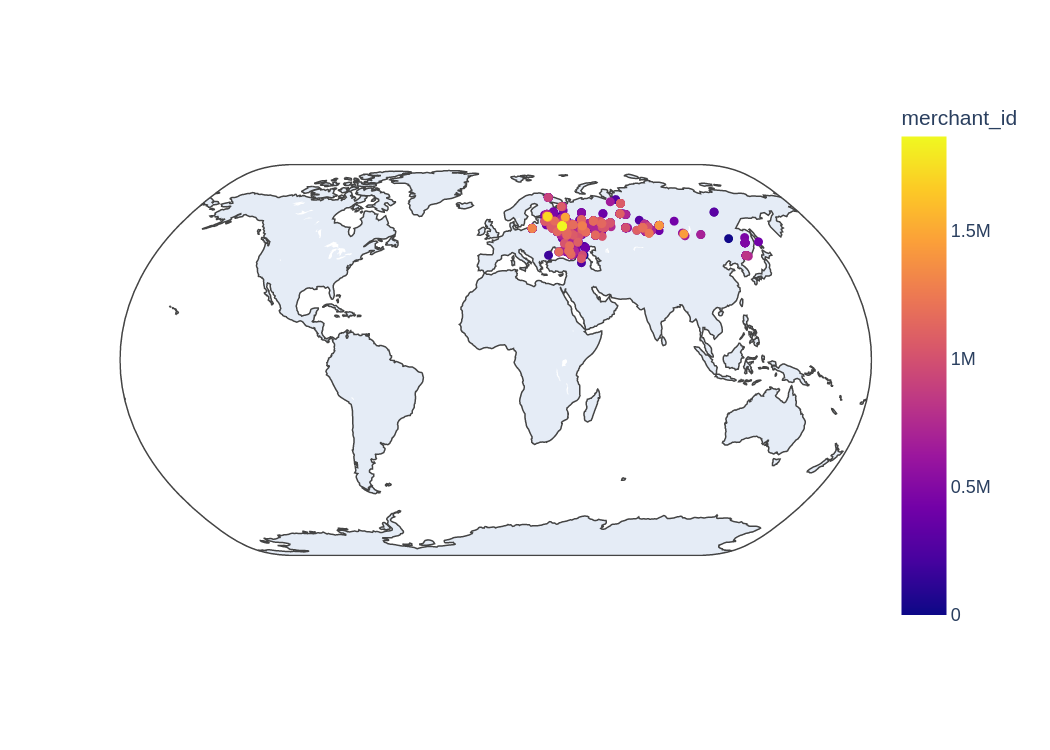

In [7]:
fig = px.scatter_geo(merchants, lon="longitude", lat='latitude',
                     color="merchant_id", projection="natural earth", hover_name='merchant_id'
)

img = plotly.io.to_image(fig, scale=1.5)
img = Image.open(io.BytesIO(img))
img.show()

Из расположения точек видно, что большая часть точек относится к РФ. Кроме этого, плотность точек в разы больше в европейской части РФ.
* **Большая часть точек** находяся в пределах РФ, но есть **наблюдения**, относящиеся к странам Европы;
* Плотность точек заметно **больше** ближе к европейской части РФ;
* Судя по всему, более "новые" мерчанты (те, у которых `id` больше) появляются в **плотных местах** (именно в плотных местах есть яркие точки).

Теперь проведем такой же анализ, но для датасета `transactions`, который содержит последовательные данные мерчантов (точнее, сообщений, отправляемых из разных точек):

In [8]:
transactions

,merchant_id,latitude,longitude,real_transaction_dttm,record_date
0,178,0.000000,0.000000,9:34:47,9:30:36
1,178,55.055996,82.912991,17:49:50,17:54:24
2,178,0.000000,0.000000,9:34:47,9:31:22
3,178,55.056034,82.912734,17:49:50,17:43:01
4,178,55.056034,82.912734,17:49:50,17:45:17
...,...,...,...,...,...
249348,1934268,59.936941,30.478357,9:22:55,9:16:57
249349,1934268,59.936941,30.478357,9:24:08,9:14:16
249350,1934268,59.936941,30.478357,9:22:55,9:14:16
249351,1934268,59.936941,30.478357,9:24:08,9:15:37


Данный датасет содержит дополнительные признаки - `real_transaction_dttm` и `record_date` (настоящее время транзакции, а также то, которое, скорее всего, записано самим мерчантом?).

Нанесем на карте мира точки расположения мерчантов, но в этот раз, по датасету `transactions`:

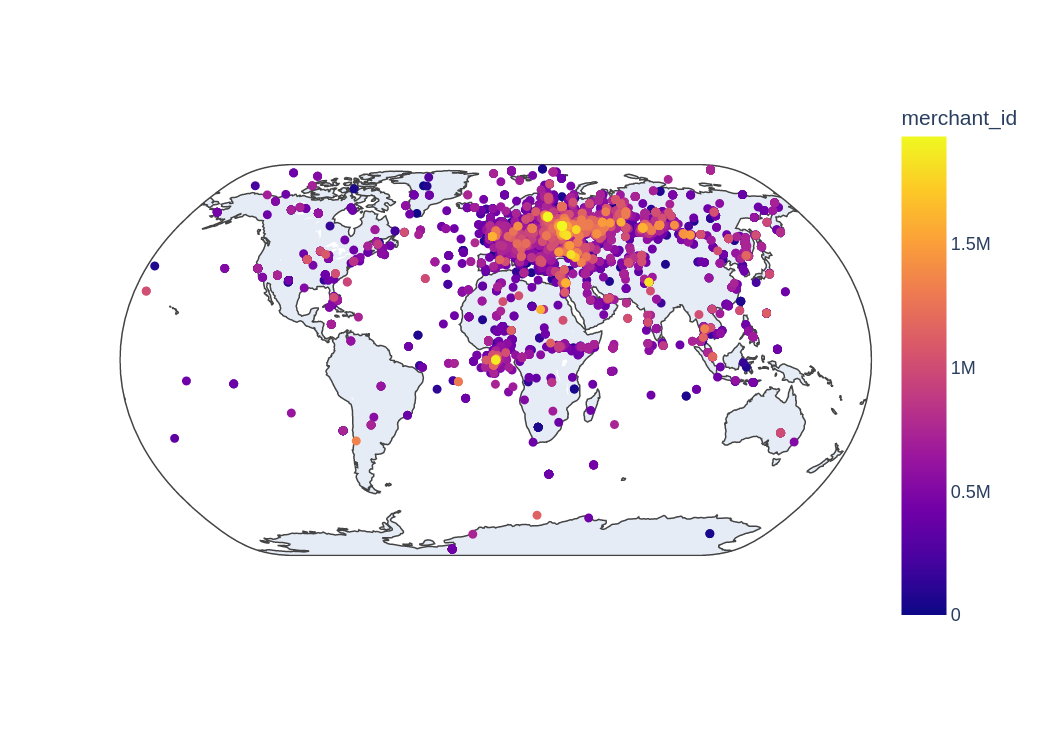

In [9]:
fig = px.scatter_geo(transactions, lon="longitude", lat='latitude',
                     color="merchant_id", projection="natural earth", hover_name='merchant_id'
)

img = plotly.io.to_image(fig, scale=1.5)
img = Image.open(io.BytesIO(img))
img.show()

Интересная ситуация получилась: в данных есть сообщения из океанов и Антарктиды. По имеющимся данным единственным разумным предположением является то, что это ошибки - возможно, мерчанты забыли включить в своем устройстве функцию "текущая локация" и отправляли рандомные локации.

Для дальнейшего анализа очистим рандомные точки по тренировочной выборке - ведь каждый объект должен быть максимально репрезентативным. Для этого поставим ограничения по минимальной/максимальной широтам и долготам, вычисленных по тренировочной выборке.

In [10]:
transactions = transactions[
    (transactions['latitude'] >= np.round(merchants['latitude'].min())) &
     (transactions['latitude'] <= np.round(merchants['latitude'].max())) &
      (transactions['longitude'] >= np.round(merchants['longitude'].min())) &
       (transactions['longitude'] <= np.round( merchants['longitude'].max()))
]

Теперь еще раз глянем на карту мира и нанесем "исправленные" локации мерчантов.

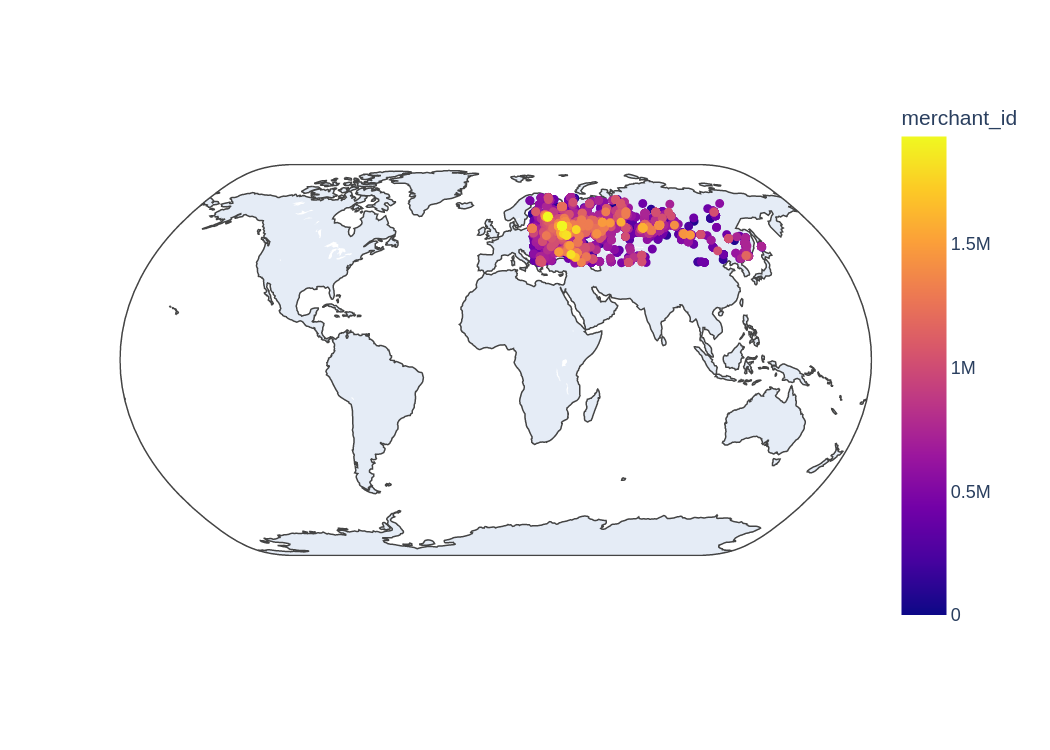

In [11]:
fig = px.scatter_geo(transactions, lon="longitude", lat='latitude',
                     color="merchant_id", projection="natural earth", hover_name='merchant_id'
)

img = plotly.io.to_image(fig, scale=1.5)
img = Image.open(io.BytesIO(img))
img.show()

Ситуация улучшилась, хоть и остались точки, которые сильно отличаются от тех,
которые представлены в тренировочной выборке. Теперь посмотрим на расположение точек по некоторым мерчантам:

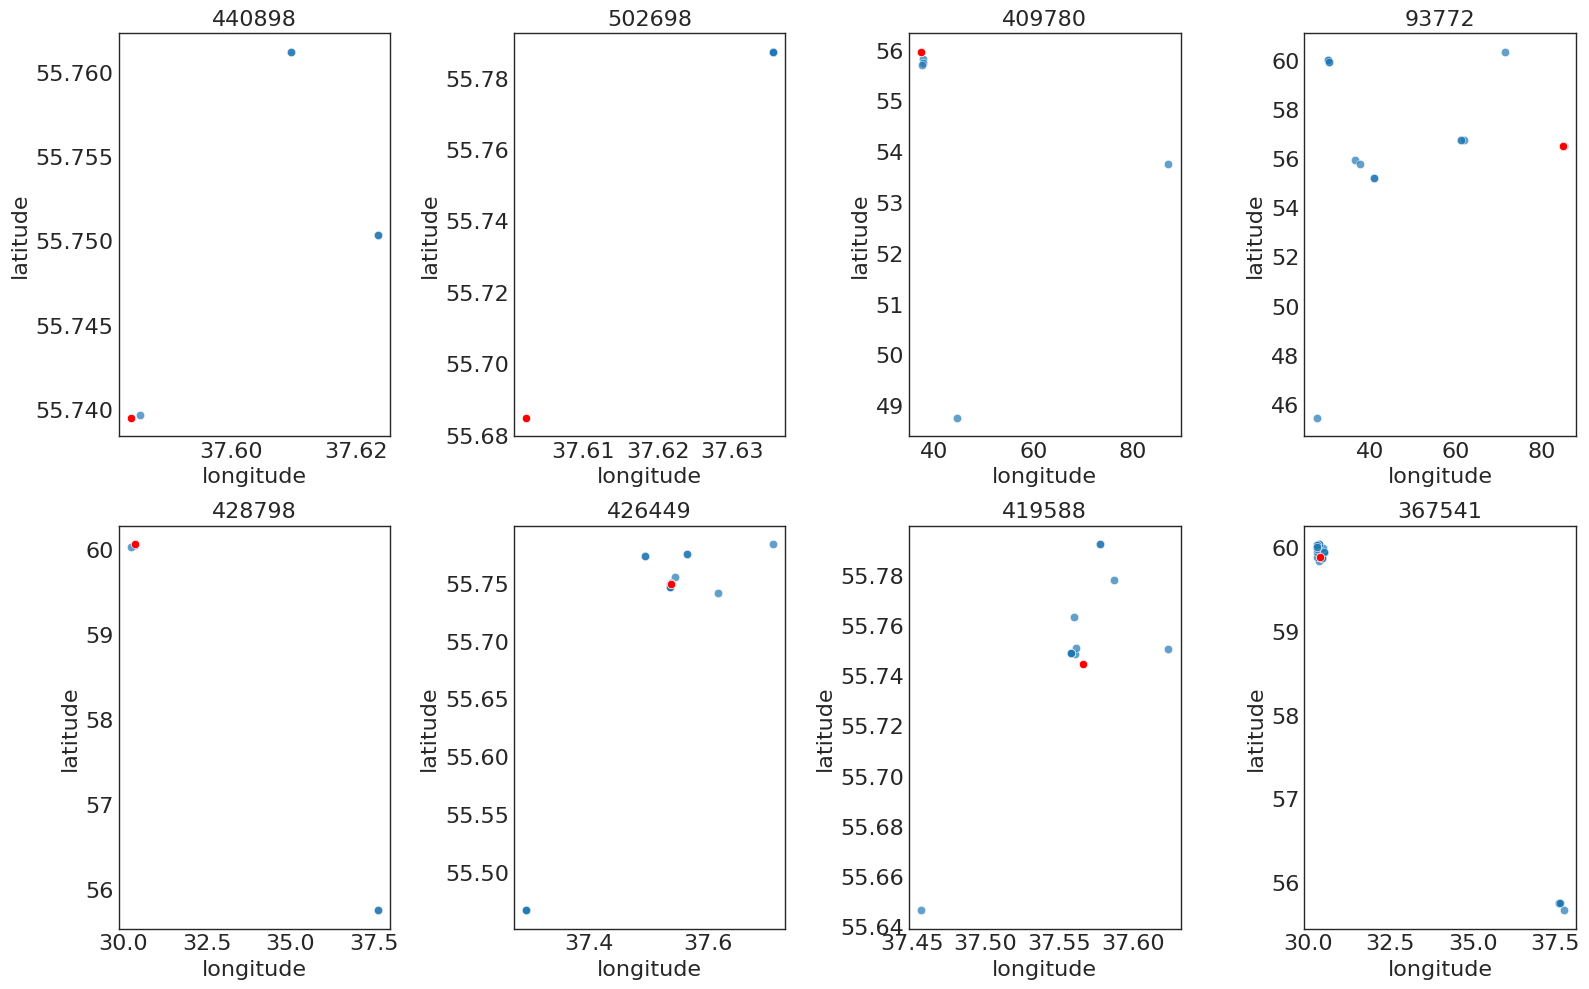

In [12]:
np.random.seed(42)

N_ROWS = 2
N_COLS = 4

fig, axes = plt.subplots(N_ROWS, N_COLS)

merchant_idxs = merchants['merchant_id'].unique()
random_merchant_idxs = np.random.choice(merchant_idxs, size=N_ROWS * N_COLS, replace=False)

for idx, ax in enumerate(axes.flatten()):
    sns.scatterplot(
        data=transactions[transactions['merchant_id'] == random_merchant_idxs[idx]],
        x="longitude", y="latitude", alpha=0.7, ax=ax
    )

    sns.scatterplot(
        data=merchants[merchants['merchant_id'] == random_merchant_idxs[idx]],
        x="longitude", y="latitude", alpha=1, ax=ax, color='red'
    )

    ax.set_title(f'{random_merchant_idxs[idx]}')

fig.tight_layout()
plt.show()

В большинстве случаев истинное расположение мерчанта находится "около" его сообщений - там, где плотность побольше. Тем не менее, есть странные мерчанты такие, как `93772` - точки его сообщений разбросаны по прямоугольнику в разные стороны.

Проверим, есть ли в данных пропущенные значения:

In [13]:
# merchants
total_nulls = merchants.isnull().sum()
total_nulls_percentage = total_nulls * 100 / len(merchants)
pd.concat([total_nulls, total_nulls_percentage],
          keys=['rows (total)', 'rows (percentage)'],
          axis=1)

,rows (total),rows (percentage)
merchant_id,0,0.0
latitude,0,0.0
longitude,0,0.0


In [14]:
# transactions
total_nulls = transactions.isnull().sum()
total_nulls_percentage = total_nulls * 100 / len(transactions)
pd.concat([total_nulls, total_nulls_percentage],
          keys=['rows (total)', 'rows (percentage)'],
          axis=1)

,rows (total),rows (percentage)
merchant_id,0,0.0
latitude,0,0.0
longitude,0,0.0
real_transaction_dttm,0,0.0
record_date,0,0.0


Пропущенных значений в данных нет.

А что можно сказать про признаки `real_transaction_dttm` и `record_date`? Давайте посмотрим. Если `real_transaction_dttm` - реальное время отправки сообщения/транзакции, то нам в идеале хотелось бы, чтобы мерчант записал эту транзакцию сразу после ее выполнения. Проверим это, но предварительно нам нужно перевести эти данные в какие-нибудь уникальные числовые - например, сконвертировать их в общее время секунд, прошедших с `00:00`. Это можем сделать с помощью `pandas`:

In [15]:
transactions['real_transaction_seconds'] = pd.to_timedelta(
    transactions['real_transaction_dttm']
).dt.total_seconds()

transactions['record_seconds'] = pd.to_timedelta(
    transactions['record_date']
).dt.total_seconds()

Теперь нарисуем зависимость обработанных признаков:

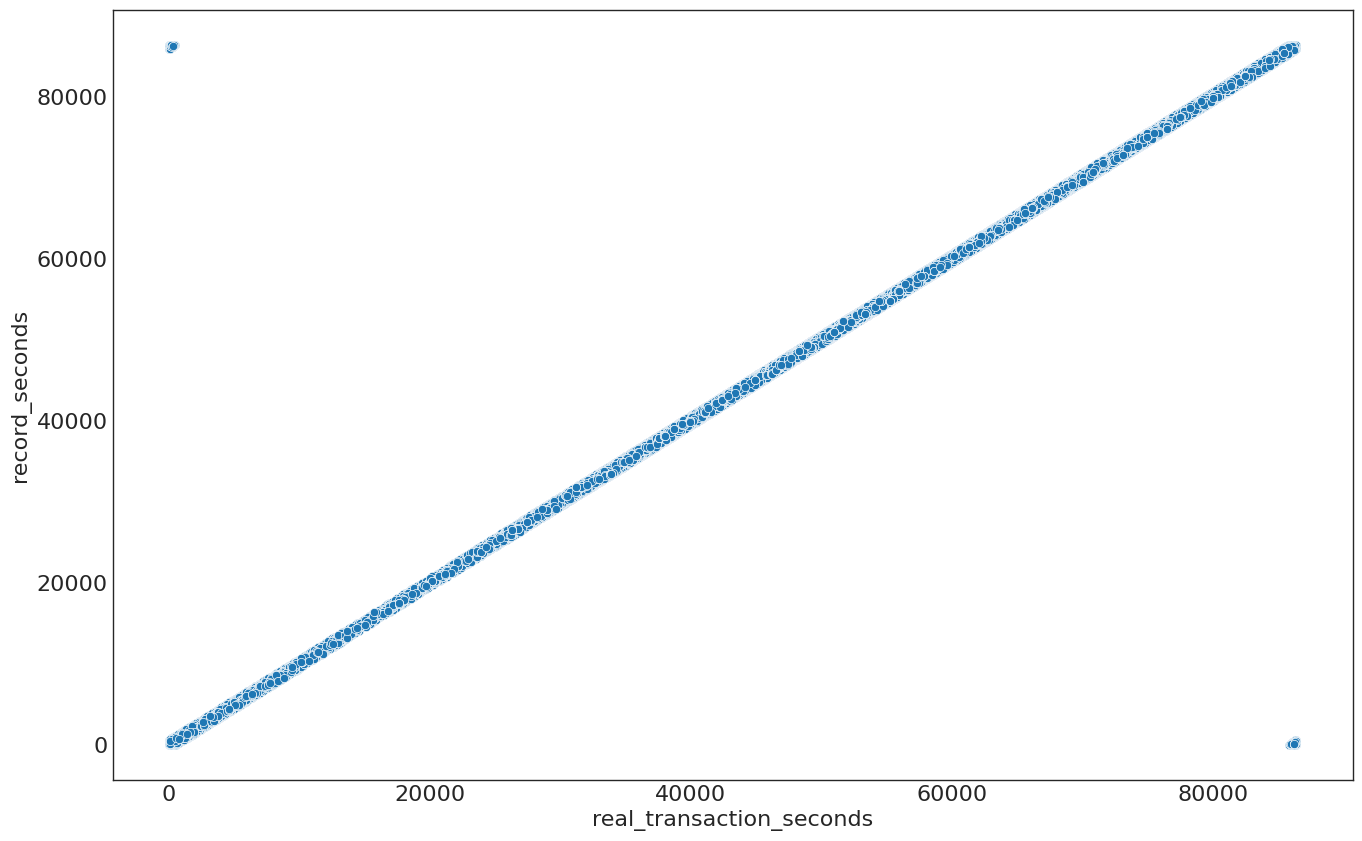

In [16]:
sns.scatterplot(transactions, x='real_transaction_seconds', y='record_seconds')

plt.show()

В целом, все лежит правильно (с погрешностью некоторой). Тем не менее, у нас по углам есть непонятные точки - скорее всего это переход в точке нуля. Попробуем задать общее число секунд, прошедших с 00:00 равным 5 и поймать такие значения (если они есть):

In [17]:
transactions[(transactions['real_transaction_seconds'] < 5)]

,merchant_id,latitude,longitude,real_transaction_dttm,record_date,real_transaction_seconds,record_seconds
34345,139937,60.054145,30.334593,0:00:01,23:57:13,1.0,86233.0
39135,139937,60.054145,30.334593,0:00:01,23:57:54,1.0,86274.0
52637,261274,55.730166,36.180401,0:00:02,23:53:31,2.0,86011.0
169799,472655,55.720513,37.808699,0:00:03,0:07:03,3.0,423.0
169811,472655,55.655050,37.582485,0:00:03,23:51:41,3.0,85901.0
169841,472655,55.655050,37.582485,0:00:03,23:50:55,3.0,85855.0


Поймали! Это на самом деле переход в нуле. Таким образом, с указанными признаками дела обстоят нормально, поэтому скорее всего ошибка в данных "внешняя" - точки разлетаются по неведомым причинам.

## Подготовка данных

Еще раз сделаем копии данных по тем же самым причинам. Правда, в этот раз, сразу обработаем выбросы, как это делали на предыдущем этапе.

In [18]:
merchants = merchants_train.copy()
transactions = transactions_full.copy()

transactions = transactions[
    (transactions['latitude'] >= np.round(merchants['latitude'].min())) &
     (transactions['latitude'] <= np.round(merchants['latitude'].max())) &
      (transactions['longitude'] >= np.round(merchants['longitude'].min())) &
       (transactions['longitude'] <= np.round( merchants['longitude'].max()))
]

Теперь ответим на главный вопрос - что и как предсказывать?

**[Что предсказываем?]**

Предсказываем `latitude` и `longitude` для каждого мерчанта. Казалось бы, очередная задача "мультиизадачной регрессии" - почти то же самое, что и задача детекции объектов, но не совсем.

Мы работаем с полу-последовательными данными (в `transactions` у нас посылаются сигнами в разное время разными мерчантами). Получается задача предсказания временных рядов? Тоже не так. Аномалий на каждого мерчанта много, как мы это увидели на этапе анализа данных, да и времена у нас не совсем последовательные - погрешности велики. Значит, задача типичной регрессии откладывается (ну или нужно как-то сгруппировать данные по мерчантам, но тогда теряется очень много информации + шумы, которые сильно повлияют на это);

Как мы видели на этапе анализа данных, истинные локации лежат в своем большинстве внутри плотного распределения точек. То есть, если бы у нас получилось как-то учесть эту информацию, то возможно, что-то бы получилось. Мне задача напоминает классические задачи из компьютерного зрения. Поясню на примере детекции объектов в грубой форме: мы создаем в изображении "кандидатов", которые на самом деле являются объектами на изображении -> с помощью вероятностной модели мы ищем максимально подходящих кандидатов на роль истинной рамки (те, которые создаются людьми) -> убираем все пересечения и оставляем рамку с наибольшим скором.

В этой задаче у нас есть кандидаты - это как раз и есть сообщения отдельных мерчантов. Как мы можем найти наиболее подходящих кандидатов на роль "истинного" расположения? Да прямо так же, как и в задаче детекции объектов - это те локации, которые лежат ближе всего к истинной локации.

В конечном итоге обучаем эту модель и оставляем локацию с наибольшим скором.

**[Как предсказываем?]**
Суммируем все то, что написано выше.
1. Создаем выборку (X, y), где X - кандидаты на роль истинной локации (мерчанты из датасета `transactions`), y - попадает ли кандидат в точку (в задачии детекции мы бы просто брали попадение внутри истинной рамки, например) $-$ *на этом этапе также генерируем фичи для кандидатов на роль истинной локации*;
2. Обучаем ML-модель на тренировочной выборке, сгенерированной из (X, y);
3. Для каждого нового мерчанта прогнозируем вероятность попадания в истинную точку;
4. Применяем сортировку к полученным вероятностям, выкидаем всех остальных кандидатов и выплевываем оставшегося кандидата.

Получается, это задача детекции объекта-локации, но без самих изображений :)

Теперь создадим пайплайн предобработки данных. Я не стал разбивать это по частям и смотреть выходы (как в основном задании про кредитный скоринг) из-за нехватки времени, вбивал выходы в консоль и делал записывал преобразования в функцию на лету.

In [19]:
def make_classification(train_labels, test_labels, transactions, eps=0.1):

    X_train = train_labels.merge(transactions,
                                 on='merchant_id',
                                 suffixes=('_true', ''))
    X_train.set_index('merchant_id', inplace=True)
    X_train['is_close'] = (
        (X_train['latitude'] - X_train['latitude_true'])**2 +
            (X_train['longitude'] - X_train['longitude_true'])**2) < eps**2

    X_test = test_labels.merge(transactions,
                               on='merchant_id',
                               suffixes=('_true', ''))
    X_test.set_index('merchant_id', inplace=True)

    return X_train, X_test

def generate_features(train, test, eps):

    tree = KDTree(train[['latitude', 'longitude']])
    train['neighbors'] = tree.query_radius(
        train[['latitude', 'longitude']],
        r=eps, count_only=True
    )
    test['neighbors'] = tree.query_radius(
        test[['latitude', 'longitude']],
        r=eps, count_only=True
    )

    train['real_transaction_dttm'] = pd.to_datetime(
        train['real_transaction_dttm'],
        format= '%H:%M:%S'
    )
    train['record_date'] = pd.to_datetime(
        train['record_date'],
        format= '%H:%M:%S'
    )

    test['real_transaction_dttm'] = pd.to_datetime(
        test['real_transaction_dttm'],
        format= '%H:%M:%S'
    )
    test['record_date'] = pd.to_datetime(
        test['record_date'],
        format= '%H:%M:%S'
    )

    train['diff_seconds'] = (
        train['record_date'] - train['real_transaction_dttm']
    ).dt.total_seconds()
    train['diff_minutes'] = train['diff_seconds'] / 60
    train['diff_hours'] = train['diff_seconds'] / (60 * 60)

    test['diff_seconds'] = (
        test['record_date'] - test['real_transaction_dttm']
    ).dt.total_seconds()
    test['diff_minutes'] = test['diff_seconds'] / 60
    test['diff_hours'] = test['diff_seconds'] / (60 * 60)

    train_grouped = train.groupby(by='merchant_id')
    train[['median_lat', 'median_lon']] = train_grouped.agg({
        'latitude': 'median',
        'longitude': 'median'
    })
    train[['mean_lat', 'mean_lon']] = train_grouped.agg({
        'latitude': 'mean',
        'longitude': 'mean'
    })
    train[['min_lat', 'min_lon']] = train_grouped.agg({
        'latitude': 'min',
        'longitude': 'min'
    })
    train[['max_lat', 'max_lon']] = train_grouped.agg({
        'latitude': 'max',
        'longitude': 'max'
    })

    test_grouped = test.groupby(by='merchant_id')
    test[['median_lat', 'median_lon']] = test_grouped.agg({
        'latitude': 'median',
        'longitude': 'median'
    })
    test[['mean_lat', 'mean_lon']] = test_grouped.agg({
        'latitude': 'mean',
        'longitude': 'mean'
    })
    test[['min_lat', 'min_lon']] = test_grouped.agg({
        'latitude': 'min',
        'longitude': 'min'
    })
    test[['max_lat', 'max_lon']] = test_grouped.agg({
        'latitude': 'max',
        'longitude': 'max'
    })

    train.drop(
        columns=[
            'latitude_true',
            'longitude_true',
            'real_transaction_dttm',
            'record_date'],
        inplace=True
    )
    test.drop(
        columns=[
            'latitude_true',
            'longitude_true',
            'real_transaction_dttm',
            'record_date'],
        inplace=True
    )

    return train, test

In [20]:
def custom_preprocessing(train_labels, test_labels, transactions,
                         eps_is_close=0.1, eps_neighbors=0.0001):
    X_train, X_test = make_classification(
        train_labels, test_labels, transactions,
        eps_is_close
    )
    X_train, X_test = generate_features(X_train, X_test, eps_neighbors)


    return X_train, X_test

X, X_test = custom_preprocessing(merchants_train, merchants_test, transactions)

X_train, X_val, y_train, y_val = train_test_split(
    X.drop('is_close', axis=1),
    X['is_close'],
    random_state=42,
    test_size=0.15
)

In [21]:
assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1]
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

## Моделирование данных

Метрикой для оценки качества алгоритма была выбрана **дистанция Винсенти** - его формулы выдают более точные результаты (см. подробнее https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude). Если вкратце, то метрикой качества является **средняя ошибка дистанций (в метрах, в нашем случае) между локацией-прогнозом и истинной локацией**.

In [22]:
def mean_distance_error(y_true, y_pred, id_col='merchant_id', nan_value=0):
    y_true, y_pred = y_true.copy(), y_pred.copy()

    def distance(row):
        true_point = (row['true_lat'], row['true_lon'])
        pred_point = (row['pred_lat'], row['pred_lon'])

        return geodesic(true_point, pred_point).meters

    if y_true.index.name != id_col:
        y_true.set_index(id_col, inplace=True)

    if y_pred.index.name != id_col:
        y_pred.set_index(id_col, inplace=True)

    y_combined = pd.merge(y_true, y_pred, how='left', left_index=True, right_index=True)
    y_combined.columns = ['true_lat', 'true_lon', 'pred_lat', 'pred_lon']
    y_combined.fillna(0, inplace=True)

    return y_combined.apply(distance, axis=1).mean()

#### Бейзлайн

Базовой моделью является **модель подсчета медиан долгот и широт по каждому мерчанту**.

пс. я посмотрел подсчет средних - но из-за того, что среднее не устойчиво к шумам, ошибка была больше на 40-50 тыс. метров.

**ВАЖНО: вам может показаться, что ошибки огромные, но на самом деле это "нормально", так как ошибка в 1 градус по долготе / широте оценивается примерно в 111 тыс. метров!!!**

In [23]:
class AggPoints:

    def __init__(self, id_col, lat_col, lon_col, method='median'):
        self.id_col = id_col
        self.lat_col = lat_col
        self.lon_col = lon_col
        self.method = method

    def fit_transform(self, X):
        X = X.groupby(by=self.id_col)

        X = X.agg({
            self.lat_col: self.method,
            self.lon_col: self.method
        })

        return X

agg_points = AggPoints(id_col='merchant_id', lat_col='latitude', lon_col='longitude', method='median')
y_pred = agg_points.fit_transform(X)

print(f'Mean distance error: {mean_distance_error(merchants, y_pred)} meters')

Mean distance error: 179781.73256315882 meters


#### Градиентный бустинг

Составим удобную функцию для сбора прогнозов (см. шаг 4 этапа "Подготовка данных"):

In [24]:
def make_predictions(estimator, X):
    X = X.copy()
    X['confidence_score'] = estimator.predict_proba(X)[:, 1]

    preds = X.reset_index()
    preds.sort_values(
        by='confidence_score', ascending=False, inplace=True
    )
    preds.drop_duplicates(subset=['merchant_id'], inplace=True)
    preds.set_index('merchant_id', inplace=True)

    return preds[['latitude', 'longitude']]

Построим модели градиентного бустинга и оценим результаты на выборке X (смещения тут особого нет, так как исходная задача поставлена таким образом, что все атрибуты вычисляются по самому мерчанту):

In [25]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred = make_predictions(gb, X.drop('is_close', axis=1))

print(f'Mean distance error: {mean_distance_error(merchants, y_pred)} meters')

Mean distance error: 164583.7126653376 meters


In [26]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred = make_predictions(xgb, X.drop('is_close', axis=1))

print(f'Mean distance error: {mean_distance_error(merchants, y_pred)} meters')

Mean distance error: 132971.43690652822 meters


In [27]:
lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)
y_pred = make_predictions(lgb, X.drop('is_close', axis=1))

print(f'Mean distance error: {mean_distance_error(merchants, y_pred)} meters')

Mean distance error: 147544.75475457587 meters


In [28]:
cgb = CatBoostClassifier(verbose=False, random_state=42)
cgb.fit(X_train, y_train)
y_pred = make_predictions(cgb, X.drop('is_close', axis=1))

print(f'Mean distance error: {mean_distance_error(merchants, y_pred)} meters')

Mean distance error: 134854.23684042756 meters


## Заключение

In [ ]:
# Составление прогнозов для тестовой выборки (наилучшая модель - XGB)

# y_pred = make_predictions(xgb, X_test)
# y_pred.to_csv(...)

**ИТОГ:** В ходе выполнения данного задания была выявлена важная проблема: не все данные из тренировочной выборки представлены в транзакциях (с тестом тоже такая же проблема). Заменять их на нуль/медиану/среднее - абсурд, так как каждый градус, как было написано ранее, дает ошибку в 111км, это сильно сместит среднюю ошибку дистанций. Решить это можно двумя способами: либо менять метрику на основе перцентилей, либо просто выбрасывать тех, кого нет. В этом случае система просто выдаст, что установить примерное расположение невозможно)) В данном решении был использован именно второй вариант (при `merge` мы не указывали `left/right`).

Что можно еще сделать, если будет время и вычислительные ресурсы:

- Подробно изучить природу выбросов: почему возникают "внешние" ошибки? может их можно будет сгладить с помощью внешней информации?
- Поработать с признаками: достать для потенциального кандидата информацию о его ближайших соседей (например, значения их признаков), добавить преобразования текущих признаков;
- Осуществить полноценный файн-тюнинг моделей бустинга (я пытался, но тут времени уходит очень много);
- Добавить блендинг, побольше моделей (ну правда это не сильно улучшит ошибку, обычно этот прием помогает набрать несколько тысяч/сотен);
- Попробовать другие подходы к постановке и решению задачи: может все таки получится настроить нетипичную регрессию? Аналогий у меня нет, а вот для классификации можно еще достать архитектуры нейроночек и наштампить поверх изображений местности (если их спарсить из Google.Maps по долготе и широте) - думаю, это может в потенциале помочь, правда очень трудозатратный подход.